In [1]:
## Import base classes
import numpy as np
import random
import sys, os

# For Interactive Plotting
from viz_util import interactive_plotting

# For Environment import 
import sys, os
sys.path.append(os.path.abspath('..'))
from environment.grid import GridEnv, Action
from enum import Enum

# For converting during training
import torch
import torch.nn as nn
import torch.nn.functional as F

# For training
from utilities import transpose_list, transpose_to_tensor

In [3]:
%load_ext autoreload
%autoreload 2
# For Agent import
from multi_ddpg import MADDPG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# --- Create Environment --- #
def create_environment(name):
    if "taxi-grid":
        env = GridEnv(num_agent = 2)
    state_space, action_space, num_agent = env.state_space, env.action_space, env.num_agent
    ##possible_actions = Action(Enum())

    print("--- Environment {} has been loaded. ---".format(name))
    print("State size: {} | Action size: {} | Number of Agents: {}".format(state_space, action_space, num_agent))
    ##print("Possible Actions: {}".format(possible_actions))
    return env, state_space, action_space.n, num_agent##, possible_actions

# --- Check example outputs --- #
def example_env_output(env):
    next_states, rewards, done = env.step([0, 1])
    print("State: ", next_states)
    print("Reward: ", rewards)
    print("Done: ", done)

In [5]:
# state_size, action_size, num_agent, possible_actions = create_environment("taxi-grid")
env, state_size, action_size, num_agent = create_environment("taxi-grid")

Not all _agents_ have fixed starting positions, rest (2) will be random
Not all _goals_ have fixed starting positions, rest (2) will be random

Final Self players:  [(5, 4), (0, 6)]
Final Self goals:  [(3, 2), (7, 1)]
--- Environment taxi-grid has been loaded. ---
State size: 8 | Action size: Discrete(4) | Number of Agents: 2


In [6]:
example_env_output(env)

State:  [[0.625, 0.375, 0.375, 0.25], [0.0, 0.875, 0.875, 0.125]]
Reward:  [-1, -1]
Done:  False


In [13]:
# Create Environment
agents = MADDPG(state_size=int(state_size/num_agent), action_size=action_size, random_seed = 1, num_agent=num_agent)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [8]:
def DDPG_eval(agents, env, max_t=100):
    states = env.reset()                                   # reset the environment & get the current state (for each agent)
    cum_scores = np.zeros(num_agent)                           # initialize the score (for each agent)
    scores = []
    episode_length = 0                                     # measure number of steps allowed before done flag
    for i in range(max_t):
        # actions = np.random.randn(num_agents, action_size) # select an action (for each agent); randomly!
        actions = agents.act([torch.from_numpy(np.array(state)).float() for state in states])           # select an action (for each agent)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        next_states, rewards, dones = env.step([np.random.choice(action_size, p=agent_action_prob.numpy()) for agent_action_prob in actions])     # send all actions to the environment, get next_state, rewards and done
        cum_scores += rewards                                  # update the score (for each agent)
        scores.append(cum_scores.copy()[0])
        states = next_states                               # roll over states to next time step
        episode_length +=1
        ##print(env.render(), end='\r')
        interactive_plotting(scores)
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode length is {}'.format(episode_length))
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(cum_scores)))

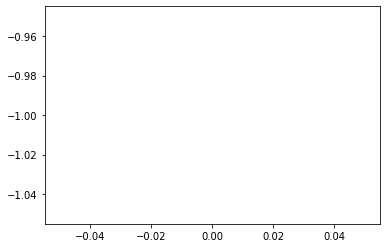

Episode length is 1
Total score (averaged over agents) this episode: -1.0


In [8]:
DDPG_eval(agents, env, 1)

In [60]:
def DDPG_train(agents, env, max_t=100, n_episodes=1):
    agents.memory.reset()
    for episode in range(n_episodes):
        states = env.reset()                                   # reset the environment & get the current state (for each agent)
        cum_scores = np.zeros(num_agent)                           # initialize the score (for each agent)
        scores = []
        episode_length = 0                                     # measure number of steps allowed before done flag
        for i in range(max_t):
            actions = agents.act([torch.from_numpy(np.array(state)).float() for state in states])           # select an action (for each agent)
            next_states, rewards, dones = env.step([np.random.choice(action_size, p=agent_action_prob.numpy()) for agent_action_prob in actions])   
            cum_scores += rewards                                  # update the score (for each agent)
            scores.append(cum_scores.copy()[0])
            states = next_states                               # roll over states to next time step
            episode_length +=1

            # flatten_full_states = [item for sublist in states for item in sublist]
            # flatten_full_next_states = [item for sublist in next_states for item in sublist]
            print(states)
            #for agent_id in range(num_agent):
            agents.memory.add(states, states, actions, rewards, next_states, next_states, dones)

            ##print(env.render(), end='\r')
            ##interactive_plotting(scores)
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        #print(len(agents.memory))
        #print(agents.memory.batch_size)
        if len(agents.memory) > agents.memory.batch_size:
            for a_i in range(num_agent):
                samples = agents.memory.sample()
                agents.update(samples, a_i)##, logger)
            agents.update_targets() #soft update the target network towards the actual networks

        # print('Episode length is {}'.format(episode_length))
        # print('Total score (averaged over agents) this episode: {}'.format(np.mean(cum_scores)))

In [61]:
DDPG_train(agents, env, 1, n_episodes=25)

[[0.875, 0.125, 0.875, 0.375], [0.75, 0.375, 0.625, 0.625]]
[[0.375, 0.625, 0.25, 0.875], [0.625, 0.625, 0.25, 0.25]]
[[0.125, 0.75, 0.875, 0.625], [0.375, 0.375, 0.625, 0.625]]
[[0.75, 0.75, 0.125, 0.25], [0.625, 0.25, 0.5, 0.0]]
[[0.75, 0.625, 0.875, 0.625], [0.25, 0.125, 0.875, 0.875]]
[[0.0, 0.125, 0.5, 0.75], [0.875, 0.375, 0.375, 0.625]]
[[0.75, 0.0, 0.5, 0.25], [0.125, 0.875, 0.75, 0.5]]
[[0.0, 0.75, 0.375, 0.25], [0.75, 0.625, 0.375, 0.375]]
[[0.75, 0.375, 0.75, 0.5], [0.375, 0.375, 0.625, 0.0]]
[[0.0, 0.875, 0.125, 0.625], [0.375, 0.25, 0.25, 0.25]]
[[0.75, 0.625, 0.125, 0.375], [0.25, 0.125, 0.5, 0.75]]
[[0.125, 0.75, 0.125, 0.625], [0.75, 0.875, 0.625, 0.5]]
[[0.25, 0.25, 0.875, 0.75], [0.25, 0.625, 0.875, 0.875]]
[[0.5, 0.625, 0.125, 0.125], [0.625, 0.625, 0.875, 0.875]]
[[0.0, 0.25, 0.25, 0.875], [0.0, 0.0, 0.25, 0.25]]
[[0.625, 0.875, 0.625, 0.5], [0.25, 0.375, 0.125, 0.125]]
[[0.375, 0.375, 0.75, 0.875], [0.0, 0.625, 0.625, 0.625]]
[[0.625, 0.0, 0.75, 0.375], [0.375, 0.0

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
import 

In [ ]:


DDPG_simple_train(agents, env, 2, 2)